# Kolhatkar et al parallels

In [1]:
# !pip3 install simpledorff
# !pip3 install krippendorff
# !pip3 install nltk
# !pip3 install py-readability-metrics
# !pip3 uninstall spacy -y

In [2]:
# !pip3 uninstall spacy -y
# !pip3 install spacy
# # !pip3 uninstall spacy-transformers -y
# # !pip3 install spacy_readability
# !python3 -m spacy download en_core_web_sm
# !pip3 install spacy-transformers
# !pip3 uninstall manual_spellchecker -y
# !pip3 uninstall autocorrect -y
# !pip3 uninstall spellchecker -y
# !pip3 install pyspellchecker
# !pip3 install sklearn-pandas
# !pip3 install tqdm>=4.61.2


In [3]:
!python3 --version
!pip3 install tqdm --upgrade

Python 3.8.10
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [4]:
import itertools
import pandas as pd
import simpledorff
import krippendorff
import nltk
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
import spacy
from tqdm import tqdm, tqdm_notebook
from spellchecker import SpellChecker
import sklearn_pandas
from sklearn_pandas import DataFrameMapper
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier


spellchk = SpellChecker()

# tqdm.pandas()
tqdm_notebook().pandas()

nlp = spacy.load("en_core_web_sm")

nltk.download('punkt')

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-_75e2q84 because the default path (/u/arunas/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
<ipython-input-4-cc521505c3c5>:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm_notebook().pandas()


A Jupyter Widget

[nltk_data] Downloading package punkt to /u/arunas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
train = pd.read_csv('../data/train-mod.csv')
test = pd.read_csv('../data/test-mod.csv')
val = pd.read_csv('../data/val-mod.csv')

In [6]:
def modify_dataframe(dataset):
    dataset_ratings = dataset.filter(regex=('author_id|participantId|noteId|output|scaling|tweet_text|summary'))
    dataset_ratings = dataset_ratings.groupby(['noteId', 'participantId', 'summary', 'tweet_text', 'tweet_author_id']).size().to_frame(name = 'count').reset_index().merge(dataset_ratings)
    dataset_ratings['full_text'] = dataset_ratings.apply(lambda row: f'<BEG> {row["tweet_text"]} <SEP> {row["summary"]} <END>', axis=1)
    dataset_unique = pd.DataFrame(dataset_ratings['full_text'].unique())
    dataset_unique['full_text'] = dataset_unique[0]
    dataset_unique = dataset_unique.drop(0, 1)
    dataset_unique['ner_count'] = dataset_unique['full_text'].apply(lambda row: len(nlp(row).ents))
    dataset_ratings = pd.merge(dataset_ratings, dataset_unique, on='full_text')
    dataset_ratings['full_text_tokens'] = dataset_ratings.apply(lambda row: nltk.word_tokenize(row['full_text']), axis=1)
    dataset_ratings['full_text_average_word_length'] = dataset_ratings.apply(lambda row: np.mean([len(token) for token in row['full_text_tokens']]), axis=1)
    dataset_ratings["full_text_sentences"] = dataset_ratings.apply(lambda row: nltk.sent_tokenize(row['full_text']), axis=1)
    dataset_ratings['full_text_sentences_mean_word_count'] = dataset_ratings.apply(lambda row: np.mean([len(sentence.split(' ')) for sentence in row['full_text_sentences']]), axis=1)
    return dataset_ratings

# Test data

In [7]:
import re
import math
import string

porter = nltk.PorterStemmer()
with open("../data/personal.txt") as f:
    personal_words = f.read().splitlines()

class TextStatistics(object):
    '''
    classdocs
    '''


    def __init__(self, text):
        '''
        Constructor
        '''
        self.text = self.clean_text(text)

    def clean_text(self, text):
        if text is None:
            return self.text

        full_stop_tags = ['li', 'p', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'dd']

        for tag_name in full_stop_tags:
            text = text.replace("</%s>" % tag_name, ".")

        """
        Regular expressions that are to be replaced
        """
        replacement_expressions = [ ["<[^>]+>", ""], #Strip tags
                                   ["[,:;()\\-]", " "],  #Replace commas, hyphens etc (count them as spaces)
                                   ["[\\.!?]", "."], #unify terminators
                                   ["^\\s+", ""], #strip leading whitespace
                                   ["[ ]*(\\n|\\r\\n|\\r)[ ]*", " "], #Replace new lines with spaces
                                   ["([\\.])[\\. ]+", "."],#check for duplicated terminators
                                   ["[ ]*([\\.])", ". "], #Pad sentence terminators
                                   ["\\s+", " "], #Remove multiple spaces
                                   ["\\s+$", ""]] #strip trailing white space

        for replacement_set in replacement_expressions:
            text = re.compile(replacement_set[0]).sub(
                                          replacement_set[1], text)

        #Add final terminator in case it's missing.
        if len(text) > 0 and text[-1] != '.':
            text += '.'

        return text

    def flesch_kincaid_reading_ease(self, text = None):
        text = self.clean_text(text)
        return round((206.835 - (1.015 * self.average_words_per_sentence(text)) - (84.6 * self.average_syllables_per_word(text)))*10)/10

    def flesch_kincaid_grade_level(self, text = None):
        text = self.clean_text(text)
        return round(((0.39 * self.average_words_per_sentence(text)) + (11.8 * self.average_syllables_per_word(text)) - 15.59)*10)/10

    def gunning_fog_score(self, text = None):
        text = self.clean_text(text)
        return round(((self.average_words_per_sentence(text) + self.percentage_words_with_three_syllables(text, False)) * 0.4)*10)/10

    def coleman_liau_index(self, text = None):
        text = self.clean_text(text)
        return round(((5.89 * (self.letter_count(text) / self.word_count(text))) - (0.3 * (self.sentence_count(text) / self.word_count(text))) - 15.8 ) *10)/10

    def smog_index(self, text = None):
        text = self.clean_text(text)
        return round(1.043 * math.sqrt((self.words_with_three_syllables(text) * (30 / self.sentence_count(text))) + 3.1291)*10)/10

    def automated_readability_index(self, text = None):
        text = self.clean_text(text)
        return round(((4.71 * (self.letter_count(text) / self.word_count(text))) + (0.5 * (self.word_count(text) / self.sentence_count(text))) - 21.43)*10)/10;




    def syllable_count(self, word):
        syllable_count = 0
        prefix_suffix_count = 0
        word_part_count = 0

        word = word.lower()
        word = re.compile("[^a-z]").sub("", word)

        problem_words = {
            "simile":        3,
            "forever":        3,
            "shoreline":    2
        }

        if word in problem_words:
            return problem_words[word]

        #These syllables would be counted as two but should be one
        sub_syllables = [
            "cial",
            "tia",
            "cius",
            "cious",
            "giu",
            "ion",
            "iou",
            "sia$",
            "[^aeiuoyt]{2,}ed$",
            ".ely$/",
            "[cg]h?e[rsd]?$",
            "rved?$",
            "[aeiouy][dt]es?$",
            "[aeiouy][^aeiouydt]e[rsd]?$",
            "^[dr]e[aeiou][^aeiou]+$", # Sorts out deal, deign etc
            "[aeiouy]rse$" # Purse, hearse
        ]

        #These syllables would be counted as one but should be two
        add_syllables = [
            "ia",
            "riet",
            "dien",
            "iu",
            "io",
            "ii",
            "[aeiouym]bl$",
            "[aeiou]{3}",
            "^mc",
            "ism$",
            "([^aeiouy])\\1l$",
            "[^l]lien",
            "^coa[dglx].",
            "[^gq]ua[^auieo]/",
            "dnt$",
            "uity$",
            "ie(r|st)$"
        ]

        # Single syllable prefixes and suffixes
        prefix_suffix = [
            "^un",
            "^fore",
            "ly$",
            "less$",
            "ful$",
            "ers?$",
            "ings?$"
        ]

        #Remove prefixes and suffixes and count how many were taken
        for current_prefix_suffix in prefix_suffix:
            pattern = re.compile(current_prefix_suffix)
            if pattern.match(word) is not None:
                word = pattern.sub("", word)
                prefix_suffix_count = prefix_suffix_count + 1

        word_parts = list(filter(textstats_is_not_whitespace,
                             re.split("[^aeiouy]+", word)))

        word_part_count = len(word_parts)
        x = 5

        syllable_count = word_part_count + prefix_suffix_count
        for current_sub in sub_syllables:
            if re.match(current_sub, word) is not None:
                syllable_count = syllable_count - 1

        for current_sub in add_syllables:
            if re.match(current_sub, word) is not None:
                syllable_count = syllable_count + 1

        return max(syllable_count, 1)

    def text_length(self, text = None):
        text = self.clean_text(text)
        return len(text)

    def letter_count(self, text = None):
        text = self.clean_text(text)
        #strangely - re.IGNORECASE will leave the last . on text
        repl = re.sub("[^a-z|A-Z]+", "", text)
        return len(repl)


    def sentence_count(self, text = None):
        text = self.clean_text(text)
        text = re.sub("[^\\.!?]", "", text)
        return max(len(text), 1)

    def words_with_three_syllables(self, text = None, count_proper_nouns = True):
        text = self.clean_text(text)
        long_word_count = 0

        word_parts = re.split("s+", text)
        for word in word_parts:
            # We don't count proper nouns or capitalised words if the countProperNouns attribute is set.
            #Defaults to true.
            if re.match("^[A-Z]", text) is None or count_proper_nouns:
                if self.syllable_count(word) > 2:
                    long_word_count += 1

        return long_word_count

    def percentage_words_with_three_syllables(self, text = None, count_proper_nouns = True):
        text = self.clean_text(text)
        return self.words_with_three_syllables(text, count_proper_nouns) / self.word_count(text)

    def word_count(self, text = None):
        text = self.clean_text(text)

        #In case of a zero length item... split will return an array of length 1
        if len(text) == 0:
            return 0

        return len(self.get_words(text))

    def get_words(self, cleaned_text):
        return re.split("[^a-zA-Z0-9]+",cleaned_text)

    def get_distinct_words(self, text = None):
        text = self.clean_text(text)
        word_arr = re.split("[^a-zA-Z0-9]+", text)
        distinct_word_arr = []
        for word in word_arr:
            word = word.lower()
            word = re.sub("[^a-zA-Z]","", word)
            if word not in distinct_word_arr:
                distinct_word_arr.append(word)

        return distinct_word_arr

    def word_count_distinct(self, text = None):
        """Count the number of distinct different words"""
        word_arr = self.get_distinct_words(text)
        return len(word_arr)



    def average_syllables_per_word(self, text = None):
        text = self.clean_text(text)

        syllable_count = 0
        word_count = self.word_count(text)
        word_arr = self.get_words(text)
        for word in word_arr:
            syllable_count += self.syllable_count(word)

        return float(max(syllable_count, 1)) / float(max(word_count, 1))

    def max_syllables_per_word(self, text = None):
        text = self.clean_text(text)

        max_value = 0
        word_arr = self.get_words(text)
        for word in word_arr:
            num_syllables = self.syllable_count(word)
            if num_syllables > max_value:
                max_value = num_syllables

        return max_value


    def average_words_per_sentence(self, text = None):
        text = self.clean_text(text)
        return float(self.word_count(text)) / float(self.sentence_count(text))

    def max_words_per_sentence(self, text = None):
        #split into sentences
        text = self.clean_text(text)
        sentence_arr = re.split("[\\.!?]", text)
        max_words = 0
        for sentence in sentence_arr:
            word_count = self.word_count(sentence)
            if word_count > max_words:
                max_words = word_count

        return max_words

def textstats_is_not_whitespace(word):
    """Utility method for filter to filter out blank words"""
    if len(re.sub("[^aeiouy]+", "", word)) > 0:
        return True
    else:
        return False

def get_readability(comment_text):
    textstat = TextStatistics("")
    text = comment_text.lower()

    #filter out punctuations
    punctuations = string.punctuation # includes following characters: !"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~
    excluded_punctuations = ["$", "%", "'"]
    for p in punctuations:
        if p not in excluded_punctuations:
            text = text.replace(p, " ")

    readability_score = textstat.smog_index(text=text)
    return readability_score


def calcPersonalXPScores(comment_text):
    # comment_text = comment_text.decode("utf-8")
    # tokenizer = WhitespaceTokenizer()
    personal_xp_score = 0
    text = comment_text.lower()

    #filter out punctuations
    punctuations = string.punctuation # includes following characters: !"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~
    excluded_punctuations = ["$", "%", "'"]
    for p in punctuations:
        if p not in excluded_punctuations:
            text = text.replace(p, " ")

    # tokenize it
    token_list = nltk.word_tokenize(comment_text)
    text_tokens = token_list
    # comment_stemmed_tokens = [porter.stem(token) for token in token_list]
    # if the tokens are in the personal_words List then increment score
    for tok in text_tokens:
        tok_stem = porter.stem(tok)
#         print(tok, tok_stem)
        if tok_stem in personal_words:
            personal_xp_score = personal_xp_score + 1

    # normalize by number of tokens
#     print(len(text_tokens), personal_xp_score)
    if len(text_tokens) > 0:
        personal_xp_score = float(personal_xp_score) / float(len(text_tokens))
#         print(personal_xp_score)
    else:
        personal_xp_score = 0.0
    return personal_xp_score

In [8]:
def get_dataframe(source):
    dataset = pd.DataFrame(source['summary'].unique())
    dataset['summary'] = dataset[0]
    dataset = dataset.drop(0, 1)
    dataset['readability'] = dataset.apply(lambda row: get_readability(row['summary']), axis=1)
    dataset['personal_description'] = dataset.apply(lambda row: calcPersonalXPScores(row['summary']), axis=1)
    dataset['tokens'] = dataset.apply(lambda row: nltk.word_tokenize(row['summary']), axis = 1)
    dataset['spell_check'] = dataset.apply(lambda row: len(spellchk.unknown(row['tokens'])), axis = 1)
    dataset['ner_count'] = dataset['summary'].apply(lambda row: len(nlp(row).ents))
    dataset['unequal'] = dataset.apply(lambda row: (row['spell_check'], row['ner_count']), axis=1)
    dataset['act_spell_check'] = dataset.apply(lambda row: row['unequal'][0] - row['unequal'][1], axis=1)
    dataset['act_spell_check'] = dataset.apply(lambda row: 0 if row['act_spell_check'] < 0 else row['act_spell_check'], axis=1)
    dataset = dataset.drop(['spell_check', 'unequal'], 1)
    dataset.rename(columns = {'act_spell_check':'spell_check'}, inplace = True)
    count = lambda l1,l2: sum([1 for x in l1 if x in l2])
    dataset['punctuation'] = dataset.apply(lambda row: count(row['summary'],set(string.punctuation)), axis = 1)
    source = source.drop(['ner_count'], 1)
    source = dataset.merge(source, on='summary')
    source = source.drop(['Unnamed: 0'], 1)
    source['length'] = source.apply(lambda row: np.array([row['full_text_average_word_length'], row['full_text_sentences_mean_word_count'], len(row['full_text_tokens']), len(row['full_text_sentences'])]), axis=1)
    source['quality'] = source.apply(lambda row: np.array([row['personal_description'], row['readability'], row['punctuation'], row['spell_check']]), axis=1)
    return source

In [9]:
train_unique = pd.DataFrame(train['summary'].unique())
train_unique['summary'] = train_unique[0]
train_unique = train_unique.drop(0, 1)


<ipython-input-9-8d64b86bb9fd>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  train_unique = train_unique.drop(0, 1)


In [10]:
train_unique['readability'] = train_unique.apply(lambda row: get_readability(row['summary']), axis=1)

In [11]:
train_unique['personal_description'] = train_unique.apply(lambda row: calcPersonalXPScores(row['summary']), axis=1)

In [12]:
train_unique['personal_description'].astype(bool).sum(axis=0)

387

In [13]:
# def autospell(text):
#     tokens = (nltk.word_tokenize(text))
#     spells = [spell(w) for w in tokens]
#     return np.where(spells != tokens)[0].size
    
# train_unique['spell checks'] = train_unique.apply(lambda row: autospell(row['summary']), axis=1)

train_unique['tokens'] = train_unique.apply(lambda row: nltk.word_tokenize(row['summary']), axis = 1)

In [14]:
train_unique['spell_check'] = train_unique.apply(lambda row: len(spellchk.unknown(row['tokens'])), axis = 1)

# print(spell)

In [15]:
train_unique['ner_count'] = train_unique['summary'].apply(lambda row: len(nlp(row).ents))

In [16]:
train_unique['unequal'] = train_unique.apply(lambda row: (row['spell_check'], row['ner_count']), axis=1)

In [17]:
train_unique['act_spell_check'] = train_unique.apply(lambda row: row['unequal'][0] - row['unequal'][1], axis=1)

In [18]:
train_unique['act_spell_check'] = train_unique.apply(lambda row: 0 if row['act_spell_check'] < 0 else row['act_spell_check'], axis=1)

In [19]:
train_unique = train_unique.drop(['spell_check', 'unequal'], 1)

<ipython-input-19-b1114bdf9d98>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  train_unique = train_unique.drop(['spell_check', 'unequal'], 1)


In [20]:
train_unique.rename(columns = {'act_spell_check':'spell_check'}, inplace = True)

In [21]:
count = lambda l1,l2: sum([1 for x in l1 if x in l2])
train_unique['punctuation'] = train_unique.apply(lambda row: count(row['summary'],set(string.punctuation)), axis = 1)

In [22]:
train = train.drop(['ner_count'], 1)
train_features = train_unique.merge(train, on='summary')

<ipython-input-22-3431f776c892>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  train = train.drop(['ner_count'], 1)


In [23]:
train_features = train_features.drop(['Unnamed: 0'], 1)

<ipython-input-23-7224c0f61c24>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  train_features = train_features.drop(['Unnamed: 0'], 1)


In [24]:
train_features['length'] = train_features.apply(lambda row: np.array([row['full_text_average_word_length'], row['full_text_sentences_mean_word_count'], len(row['full_text_tokens']), len(row['full_text_sentences'])]), axis=1)

In [25]:
train_features['quality'] = train_features.apply(lambda row: np.array([row['personal_description'], row['readability'], row['punctuation'], row['spell_check']]), axis=1)

In [26]:
train_features.columns

Index(['summary', 'readability', 'personal_description', 'tokens', 'ner_count',
       'spell_check', 'punctuation', 'noteId', 'participantId', 'tweet_text',
       'tweet_author_id', 'count', 'output', 'scaling', 'full_text',
       'full_text_tokens', 'full_text_average_word_length',
       'full_text_sentences', 'full_text_sentences_mean_word_count', 'length',
       'quality'],
      dtype='object')

In [27]:
test_features = get_dataframe(test)
val_features = get_dataframe(val)

<ipython-input-8-32be62c04170>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  dataset = dataset.drop(0, 1)
<ipython-input-8-32be62c04170>:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  dataset = dataset.drop(['spell_check', 'unequal'], 1)
<ipython-input-8-32be62c04170>:17: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  source = source.drop(['ner_count'], 1)
<ipython-input-8-32be62c04170>:19: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  source = source.drop(['Unnamed: 0'], 1)


In [28]:
test.columns, val.columns

(Index(['Unnamed: 0', 'noteId', 'participantId', 'summary', 'tweet_text',
        'tweet_author_id', 'count', 'output', 'scaling', 'full_text',
        'ner_count', 'full_text_tokens', 'full_text_average_word_length',
        'full_text_sentences', 'full_text_sentences_mean_word_count'],
       dtype='object'),
 Index(['Unnamed: 0', 'noteId', 'participantId', 'summary', 'tweet_text',
        'tweet_author_id', 'count', 'output', 'scaling', 'full_text',
        'ner_count', 'full_text_tokens', 'full_text_average_word_length',
        'full_text_sentences', 'full_text_sentences_mean_word_count'],
       dtype='object'))

In [ ]:
clf = sklearn.svm.SVC(kernel='linear', verbose=1)
X =  np.array(list(train_features['length']))
y =  np.array(list(train_features['output']))
print(type(X), type(y))
scaling = np.array(list(train_features['scaling']))
clf.fit(X, y, sample_weight=scaling)

In [ ]:
clf.score(np.array(list(test_features['length'])), np.array(list(test_features['output'])))

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(verbose=1)
logreg.fit(X, y, sample_weight=scaling)

In [33]:
logreg.score(np.array(list(test_features['length'])), np.array(list(test_features['output'])))

0.6603216903017036

In [34]:
clf = sklearn.svm.SVC(kernel='linear', verbose=1)
X1 =  np.array(list(train_features['quality']))
y =  np.array(list(train_features['output']))
print(type(X1), type(y))
scaling = np.array(list(train_features['scaling']))
clf.fit(X1, y, sample_weight=scaling)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[LibSVM]

SVC(kernel='linear', verbose=1)

In [35]:
clf.score(np.array(list(test_features['quality'])), np.array(list(test['output'])))

0.6603216903017036

In [36]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(verbose=1)
logreg.fit(X1, y, sample_weight=scaling)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


LogisticRegression(verbose=1)

In [37]:
logreg.score(np.array(list(test_features['quality'])), np.array(list(test['output'])))

0.6706005520129438

In [40]:
clf = sklearn.svm.SVC(kernel='linear', verbose=1)
X2 =  np.array(list(train_features['ner_count'])).reshape((-1, 1))
y =  np.array(list(train_features['output']))
print(type(X2), type(y))
scaling = np.array(list(train_features['scaling']))
clf.fit(X2, y, sample_weight=scaling)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[LibSVM]

SVC(kernel='linear', verbose=1)

In [42]:
clf.score(np.array(list(test_features['ner_count'])).reshape((-1, 1)), np.array(list(test['output'])))

0.6603216903017036

In [47]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(verbose=1)
logreg.fit(X2, y, sample_weight=scaling)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


LogisticRegression(verbose=1)

In [48]:
logreg.score(np.array(list(test_features['ner_count'])).reshape((-1, 1)), np.array(list(test['output'])))

0.6603216903017036

In [53]:
clf = sklearn.svm.SVC(kernel='linear', verbose=1)
X2 =  np.array(list(train_features['ner_count'])).reshape((-1, 1))
y =  np.array(list(train_features['output']))
print(type(X2), type(y), X2.shape, y.shape)
scaling = np.array(list(train_features['scaling']))
clf.fit(X2, y, sample_weight=scaling)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> (88185, 1) (88185,)
[LibSVM]

SVC(kernel='linear', verbose=1)

In [54]:
predictions = np.ones(test['output'].shape)

In [56]:
np.mean(predictions == test['output'])

0.6603216903017036

(array([31347.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 56838.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

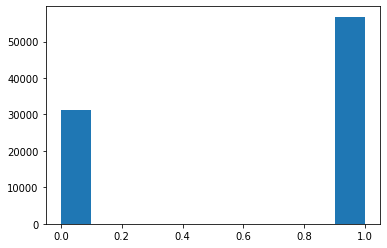

In [61]:
plt.hist(train_features['output'])

(array([3569.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        6938.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

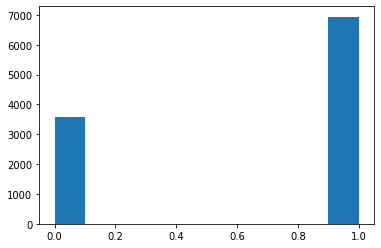

In [62]:
plt.hist(test_features['output'])

(array([4170.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        7471.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

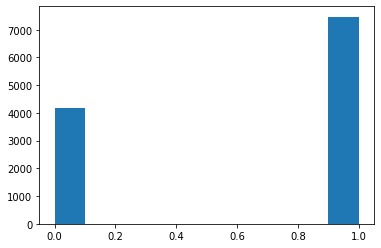

In [63]:
plt.hist(val_features['output'])

# With class_weight

In [33]:
clf_length = sklearn.svm.SVC(kernel='linear', verbose=True, class_weight='balanced')
X =  np.array(list(train_features['length']))
y =  np.array(list(train_features['output']))
print(type(X), type(y))
scaling = np.array(list(train_features['scaling']))
clf_length.fit(X, y, sample_weight=scaling)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[LibSVM]

SVC(class_weight='balanced', kernel='linear', verbose=True)

In [43]:
y_pred = clf_length.predict(np.array(list(test_features['length'])))

ValueError: X has 4 features, but SVC is expecting 1 features as input.

In [34]:
clf_length.score(np.array(list(test_features['length'])), np.array(list(test_features['output'])))

0.54677833825069

In [35]:
from sklearn.linear_model import LogisticRegression
logreg_length = LogisticRegression(class_weight='balanced')
logreg_length.fit(X, y, sample_weight=scaling)

LogisticRegression(class_weight='balanced')

In [36]:
logreg_length.score(np.array(list(test_features['length'])), np.array(list(test_features['output'])))

0.530122775292662

In [37]:
clf_quality = sklearn.svm.SVC(kernel='linear', class_weight='balanced')
X1 =  np.array(list(train_features['quality']))
y =  np.array(list(train_features['output']))
print(type(X1), type(y))
scaling = np.array(list(train_features['scaling']))
clf_quality.fit(X1, y, sample_weight=scaling)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


SVC(class_weight='balanced', kernel='linear')

In [38]:
clf_quality.score(np.array(list(test_features['quality'])), np.array(list(test['output'])))

0.48500999333777484

In [39]:
from sklearn.linear_model import LogisticRegression
logreg_quality = LogisticRegression(class_weight='balanced')
logreg_quality.fit(X1, y, sample_weight=scaling)

LogisticRegression(class_weight='balanced')

In [40]:
logreg_quality.score(np.array(list(test_features['quality'])), np.array(list(test['output'])))

0.5407823355857999

In [48]:
 y_logreg_quality_pred = logreg_quality.predict(np.array(list(test_features['ner_count'])).reshape((-1, 1)))

In [49]:
 sklearn.metrics.f1_score(test_features['output'], y_logreg_quality_pred, sample_weight=test_features['scaling'])

0.48264882537735443

In [51]:
sklearn.metrics.precision_score(test_features['output'], y_logreg_quality_pred, sample_weight=test_features['scaling'])

0.6882557610583585

In [53]:
sklearn.metrics.recall_score(test_features['output'], y_logreg_quality_pred, sample_weight=test_features['scaling'])

0.3716295979749051

In [55]:
sklearn.metrics.average_precision_score(test_features['output'], y_logreg_quality_pred, sample_weight=test_features['scaling'])

0.6590934124364873

In [56]:
sklearn.metrics.roc_auc_score(test_features['output'], y_logreg_quality_pred, sample_weight=test_features['scaling'])

0.5349838616481061

# NER COUNT - SVM

In [41]:
clf_ner_count = sklearn.svm.SVC(kernel='linear', class_weight='balanced')
X2 =  np.array(list(train_features['ner_count'])).reshape((-1, 1))
y =  np.array(list(train_features['output']))
print(type(X2), type(y))
scaling = np.array(list(train_features['scaling']))
clf_ner_count.fit(X2, y, sample_weight=scaling)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


SVC(class_weight='balanced', kernel='linear')

In [42]:
clf_ner_count.score(np.array(list(test_features['ner_count'])).reshape((-1, 1)), np.array(list(test['output'])))

0.414771104977634

In [48]:
 y_svm_ner_count_pred = logreg_ner_count.predict(np.array(list(test_features['ner_count'])).reshape((-1, 1)))

In [49]:
 sklearn.metrics.f1_score(test_features['output'], y_svm_ner_count_pred, sample_weight=test_features['scaling'])

0.48264882537735443

In [51]:
sklearn.metrics.precision_score(test_features['output'], y_svm_ner_count_pred, sample_weight=test_features['scaling'])

0.6882557610583585

In [53]:
sklearn.metrics.recall_score(test_features['output'], y_svm_ner_count_pred, sample_weight=test_features['scaling'])

0.3716295979749051

In [55]:
sklearn.metrics.average_precision_score(test_features['output'], y_svm_ner_count_pred, sample_weight=test_features['scaling'])

0.6590934124364873

In [56]:
sklearn.metrics.roc_auc_score(test_features['output'], y_svm_ner_count_pred, sample_weight=test_features['scaling'])

0.5349838616481061

# NER COUNT - LogReg

In [44]:
logreg_ner_count = LogisticRegression(class_weight='balanced')
logreg_ner_count.fit(X2, y, sample_weight=scaling)

LogisticRegression(class_weight='balanced')

In [47]:
logreg_ner_count.score(np.array(list(test_features['ner_count'])).reshape((-1, 1)), np.array(list(test['output'])))

0.4505567716760255

In [48]:
 y_logreg_ner_count_pred = logreg_ner_count.predict(np.array(list(test_features['ner_count'])).reshape((-1, 1)))

In [49]:
 sklearn.metrics.f1_score(test_features['output'], y_logreg_ner_count_pred, sample_weight=test_features['scaling'])

0.48264882537735443

In [51]:
sklearn.metrics.precision_score(test_features['output'], y_logreg_ner_count_pred, sample_weight=test_features['scaling'])

0.6882557610583585

In [53]:
sklearn.metrics.recall_score(test_features['output'], y_logreg_ner_count_pred, sample_weight=test_features['scaling'])

0.3716295979749051

In [55]:
sklearn.metrics.average_precision_score(test_features['output'], y_logreg_ner_count_pred, sample_weight=test_features['scaling'])

0.6590934124364873

In [56]:
sklearn.metrics.roc_auc_score(test_features['output'], y_logreg_ner_count_pred, sample_weight=test_features['scaling'])

0.5349838616481061

In [29]:
def get_metrics_svm(attribute):
    svm = sklearn.svm.SVC(kernel='linear', class_weight='balanced')
    if len(np.array(list(train_features[attribute])).shape) < 2:
        X =  np.array(list(train_features[attribute])).reshape((-1, 1))
    else:
        X =  np.array(list(train_features[attribute]))
    y =  np.array(list(train_features['output']))
    scaling = np.array(list(train_features['scaling']))
    svm.fit(X, y, sample_weight=scaling)
    if len(np.array(list(train_features[attribute])).shape) < 2:
        accuracy = svm.score(np.array(list(test_features[attribute])).reshape((-1,1)), np.array(list(test['output'])))
    else:
        accuracy = svm.score(np.array(list(test_features[attribute])), np.array(list(test['output'])))
    if len(np.array(list(train_features[attribute])).shape) < 2:
        y_pred = svm.predict(np.array(list(test_features[attribute])).reshape((-1,1)))
    else:
        y_pred = svm.predict(np.array(list(test_features[attribute])))
    f1 = sklearn.metrics.f1_score(test_features['output'], y_pred, sample_weight=test_features['scaling'])
    precision = sklearn.metrics.precision_score(test_features['output'], y_pred, sample_weight=test_features['scaling'])
    recall = sklearn.metrics.recall_score(test_features['output'], y_pred, sample_weight=test_features['scaling'])
    avg_precision = sklearn.metrics.average_precision_score(test_features['output'], y_pred, sample_weight=test_features['scaling'])
    roc_auc = sklearn.metrics.roc_auc_score(test_features['output'], y_pred, sample_weight=test_features['scaling'])
    return f'SVM: {attribute}, accuracy: {accuracy}, f1: {f1}, precision: {precision}, recall: {recall}, average precision: {avg_precision}, roc_auc: {roc_auc}'

def get_metrics_log_reg(attribute):
    logreg = LogisticRegression(class_weight='balanced')
    if len(np.array(list(train_features[attribute])).shape) < 2:
        X =  np.array(list(train_features[attribute])).reshape((-1, 1))
    else:
        X =  np.array(list(train_features[attribute]))
    y =  np.array(list(train_features['output']))
    scaling = np.array(list(train_features['scaling']))
    logreg.fit(X, y, sample_weight=scaling)
    if len(np.array(list(train_features[attribute])).shape) < 2:
        accuracy = logreg.score(np.array(list(test_features[attribute])).reshape((-1,1)), np.array(list(test['output'])))
    else:
        accuracy = logreg.score(np.array(list(test_features[attribute])), np.array(list(test['output'])))
    if len(np.array(list(train_features[attribute])).shape) < 2:
        y_pred = logreg.predict(np.array(list(test_features[attribute])).reshape((-1,1)))
    else:
        y_pred = logreg.predict(np.array(list(test_features[attribute])))
    f1 = sklearn.metrics.f1_score(test_features['output'], y_pred, sample_weight=test_features['scaling'])
    precision = sklearn.metrics.precision_score(test_features['output'], y_pred, sample_weight=test_features['scaling'])
    recall = sklearn.metrics.recall_score(test_features['output'], y_pred, sample_weight=test_features['scaling'])
    avg_precision = sklearn.metrics.average_precision_score(test_features['output'], y_pred, sample_weight=test_features['scaling'])
    roc_auc = sklearn.metrics.roc_auc_score(test_features['output'], y_pred, sample_weight=test_features['scaling'])
    return f'Logistic Regression: {attribute}, accuracy: {accuracy}, f1: {f1}, precision: {precision}, recall: {recall}, average precision: {avg_precision}, roc_auc: {roc_auc}'

def get_metrics_rf(attribute):
    seed = 50
    rf = RandomForestClassifier(
                      min_samples_leaf=50,
                      n_estimators=1500,
                      bootstrap=True,
                      oob_score=True,
                      n_jobs=-1,
                      random_state=seed,
                      max_features='auto',
                      class_weight='balanced')
    if len(np.array(list(train_features[attribute])).shape) < 2:
        X =  np.array(list(train_features[attribute])).reshape((-1, 1))
    else:
        X =  np.array(list(train_features[attribute]))
    y =  np.array(list(train_features['output']))
    scaling = np.array(list(train_features['scaling']))
    rf.fit(X, y, sample_weight=scaling)
    if len(np.array(list(train_features[attribute])).shape) < 2:
        accuracy = rf.score(np.array(list(test_features[attribute])).reshape((-1,1)), np.array(list(test['output'])))
    else:
        accuracy = rf.score(np.array(list(test_features[attribute])), np.array(list(test['output'])))
    if len(np.array(list(train_features[attribute])).shape) < 2:
        y_pred = rf.predict(np.array(list(test_features[attribute])).reshape((-1,1)))
    else:
        y_pred = rf.predict(np.array(list(test_features[attribute])))
    f1 = sklearn.metrics.f1_score(test_features['output'], y_pred, sample_weight=test_features['scaling'])
    precision = sklearn.metrics.precision_score(test_features['output'], y_pred, sample_weight=test_features['scaling'])
    recall = sklearn.metrics.recall_score(test_features['output'], y_pred, sample_weight=test_features['scaling'])
    avg_precision = sklearn.metrics.average_precision_score(test_features['output'], y_pred, sample_weight=test_features['scaling'])
    roc_auc = sklearn.metrics.roc_auc_score(test_features['output'], y_pred, sample_weight=test_features['scaling'])
    return f'Random Forest: {attribute}, accuracy: {accuracy}, f1: {f1}, precision: {precision}, recall: {recall}, average precision: {avg_precision}, roc_auc: {roc_auc}'

    

In [30]:
print(get_metrics_svm('ner_count'))
print(get_metrics_log_reg('ner_count'))

SVM: ner_count, accuracy: 0.414771104977634, f1: 0.35446524013483055, precision: 0.7135805140955456, recall: 0.23579796909871645, average precision: 0.6587610614224928, roc_auc: 0.5330920837908776
Logistic Regression: ner_count, accuracy: 0.4505567716760255, f1: 0.48264882537735443, precision: 0.6882557610583585, recall: 0.3716295979749051, average precision: 0.6590934124364873, roc_auc: 0.5349838616481061


In [31]:
print(get_metrics_svm('quality'))
print(get_metrics_log_reg('quality'))

SVM: quality, accuracy: 0.48500999333777484, f1: 0.5362098717793582, precision: 0.7275435539965197, recall: 0.42455729713131396, average precision: 0.6782296790345478, roc_auc: 0.569814379845463
Logistic Regression: quality, accuracy: 0.5407823355857999, f1: 0.6199120524096, precision: 0.7159046177743338, recall: 0.5466183528536525, average precision: 0.6823279234696285, roc_auc: 0.5789411730726411


In [53]:
print(get_metrics_svm('length'))
print(get_metrics_log_reg('length'))

SVM: length, accuracy: 0.5441134481774056, f1: 0.6406678702564477, precision: 0.7221161181632643, recall: 0.5757306011017966, average precision: 0.6880600792380256, roc_auc: 0.5893439664382519
Logistic Regression: length, accuracy: 0.5263157894736842, f1: 0.6058176037263575, precision: 0.7187743254108871, recall: 0.5235420043067095, average precision: 0.6821213397823485, roc_auc: 0.5782247605197893


In [71]:
print(get_metrics_rf('ner_count'))
print(get_metrics_rf('quality'))
print(get_metrics_rf('length'))

Random Forest: ner_count, accuracy: 0.5389740173217855, f1: 0.6210280988035914, precision: 0.6779465488416294, recall: 0.572926805548559, average precision: 0.6625290887494052, roc_auc: 0.5425906959663964
Random Forest: quality, accuracy: 0.5861806414771105, f1: 0.6989372390151177, precision: 0.7248917088342361, recall: 0.6747771034358027, average precision: 0.6978834316701904, roc_auc: 0.6079203892582593
Random Forest: length, accuracy: 0.5840867992766727, f1: 0.6936877068383339, precision: 0.702266679930583, recall: 0.6853158076136804, average precision: 0.6832533329955931, roc_auc: 0.5823138397947051


In [32]:
train_features['all'] = train_features.apply(lambda row: list(itertools.chain(row['length'], row['quality'], [row['ner_count']])), axis=1)

In [33]:
test_features['all'] = test_features.apply(lambda row: list(itertools.chain(row['length'], row['quality'], [row['ner_count']])), axis=1)
val_features['all'] = val_features.apply(lambda row: list(itertools.chain(row['length'], row['quality'], [row['ner_count']])), axis=1)


In [34]:
print(get_metrics_log_reg('all'))

/u/arunas/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression: all, accuracy: 0.5213667079090131, f1: 0.606418347113234, precision: 0.7260169289183717, recall: 0.520650319711153, average precision: 0.6856697519501522, roc_auc: 0.5842676014642383


In [35]:
print(get_metrics_rf('all'))

Random Forest: all, accuracy: 0.5891310554868183, f1: 0.7190539202051455, precision: 0.7216845120406783, recall: 0.7164424361125497, average precision: 0.6990457754945192, roc_auc: 0.6106484654921459


In [36]:
print(get_metrics_svm('all'))

SVM: all, accuracy: 0.5374512229941943, f1: 0.6268917145829604, precision: 0.7232104405399724, recall: 0.5532135421272645, average precision: 0.6868580323605471, roc_auc: 0.5868884060201726
